In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import pathlib
from google.cloud import storage
import tensorflow_hub as hub
from io import BytesIO
from tensorflow.python.lib.io import file_io
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [2]:
train_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren_4classes_balanced.csv", header=None)
val_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren_grouped_classes.csv", header=None)
test_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren_grouped_classes.csv", header=None)
CLASS_NAMES = train_data[0].unique()

In [3]:
# def check_data(data):
#     no_series = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/data_without_series.csv")
#     z_score = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/data_without_zScore.csv")
#     overexposed = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/overexposed.csv")
#     underexposed = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/underexposed.csv")
    
#     data[1] = data[1].map(lambda x: x.lstrip('../gabon-dataset/data_training_rescaled_extra/'))
#     new_data = no_series.merge(data, left_on='pictures', right_on=1)
#     new_data = new_data[[0, 1]]
#     new_data[1] = '../gabon-dataset/data_training_rescaled_extra/' + new_data[1]
#     return new_data       

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

BATCH_SIZE = 128
# 10 is a magic number tuned for local training of this dataset.
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_IMAGES = 370
VALIDATION_STEPS = VALIDATION_IMAGES // BATCH_SIZE

In [5]:
def decode_img(img, reshape_dims):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

In [6]:
MAX_DELTA = 63.0 / 255.0  # Change brightness by at most 17.7%
CONTRAST_LOWER = 0.2
CONTRAST_UPPER = 1.8

def read_and_preprocess(image_bytes, label, random_augment=False):
#     if random_augment:
#         img = decode_img(image_bytes, [IMG_HEIGHT + 10, IMG_WIDTH + 10])
#         img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_brightness(img, MAX_DELTA)
#         img = tf.image.random_contrast(img, CONTRAST_LOWER, CONTRAST_UPPER)
#     else:
    img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
    return img, label


def read_and_preprocess_with_augment(image_bytes, label):
    return read_and_preprocess(image_bytes, label, random_augment=True)

In [7]:
def decode_csv(csv_row):
    record_defaults = ["img", "path"]
    label_string, filename = tf.io.decode_csv(csv_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    label = tf.math.equal(CLASS_NAMES, label_string)
    return image_bytes, label

In [8]:
def load_dataset(csv_of_filenames, batch_size, training=True):    
    dataset = tf.data.TextLineDataset(filenames=csv_of_filenames) \
        .map(decode_csv, num_parallel_calls=tf.data.AUTOTUNE)
    
    if training:
        dataset = dataset \
            .map(read_and_preprocess_with_augment, num_parallel_calls=tf.data.AUTOTUNE) \
            .repeat(count=1)
        
#             .shuffle(SHUFFLE_BUFFER) \
#             .repeat(count=-1)
#             .repeat(count=None)  # Indefinately.

#         dataset = dataset \
#             .map(read_and_preprocess_with_augment) \
#             .shuffle(SHUFFLE_BUFFER) \
#             .repeat(count=None)  # Indefinately.
    else:
        dataset = dataset \
            .map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
            .repeat(count=1)  # Each photo used once.
    
    # Prefetch prepares the next set of batches while current batch is in use.
    return dataset.batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)
#     return dataset.range(4).interleave(lambda _: dataset.batch(batch_size=batch_size), num_parallel_calls=tf.data.AUTOTUNE )

# Model

In [9]:
# data
train_path = "gs://dataset-gabon/train_val_test_csv_Siebren/train_data_siebren_4classes_balanced.csv"
eval_path = "gs://dataset-gabon/train_val_test_csv_Siebren/val_data_siebren_4classes_balanced.csv"
nclasses = len(CLASS_NAMES)

In [10]:
nclasses

4

In [11]:
base_model = keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [12]:
base_model.trainable = False

In [13]:
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(rate=0.5)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nclasses, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [15]:
# model.load_weights("gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_grouped_classes/cp.ckpt")
# model = keras.models.load_model("gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_grouped_classes/model.H5")

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [17]:
# for layer in model.layers[1].layers:
#     print(layer)

In [18]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_grouped_4classes/cp.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

In [19]:
history = model.fit(train_ds,
            epochs=3,
#             steps_per_epoch=(len(train_data) // BATCH_SIZE),
            validation_data=eval_ds,
            callbacks=[cp_callback]
#             validation_steps=(len(val_data) // BATCH_SIZE)
         )

Epoch 1/3


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Expect 2 fields but have 3 in record 0
	 [[{{node DecodeCSV}}]]
	 [[IteratorGetNext]]
  (1) Invalid argument:  Expect 2 fields but have 3 in record 0
	 [[{{node DecodeCSV}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_8437]

Function call stack:
train_function -> train_function


In [17]:
model.trainable = True
# BATCH_SIZE =64

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [19]:
history = model.fit(train_ds,
            epochs=1,
#             steps_per_epoch=(len(train_data) // BATCH_SIZE),
            validation_data=eval_ds,
#             validation_steps=(len(val_data) // BATCH_SIZE)
         )

1902/1902 [==============================] - 3089s 2s/step - loss: 0.7178 - accuracy: 0.7536 - val_loss: 0.3015 - val_accuracy: 0.8953


# save model

In [82]:
tf.keras.models.save_model(model, "gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_grouped_4classes/model.H5", 
                           include_optimizer=False)

INFO:tensorflow:Assets written to: gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_grouped_4classes/model.H5/assets


# Test myanmarData

In [80]:
test_data_myan = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_myanmar_siebren.csv", header=None)
test_path_myan = "gs://dataset-gabon/train_val_test_csv_Siebren/test_data_myanmar_siebren.csv"
test_ds_myan = load_dataset(test_path_myan, BATCH_SIZE, training=False)

In [81]:
test_loss, test_acc = model.evaluate(eval_ds , verbose=1)
print(test_acc)

476/476 [==============================] - 137s 287ms/step - loss: 2.8449 - accuracy: 0.7880
0.7880210876464844


In [46]:
PREDICTIONS = len(test_data_myan)//BATCH_SIZE
y_test = []
counter = 0
for i in tqdm(test_ds_myan):
    if counter < PREDICTIONS:
        counter += 1
        for j in i[1]:
            y_test.append(np.where(j == True)[0][0])
    else:
        break
print(len(y_test))

62it [06:24,  6.20s/it]

7936


In [47]:
y_pred = model.predict(test_ds_myan, steps=PREDICTIONS)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = y_test
y, idx = tf.unique(predicted_categories)
cm = confusion_matrix(predicted_categories, true_categories, normalize="pred", labels=y.numpy())
cmn = cm
df_cm = pd.DataFrame(cmn, index = [CLASS_NAMES[i] for i in y.numpy()],
                  columns = [CLASS_NAMES[i] for i in y.numpy()])

<AxesSubplot:>

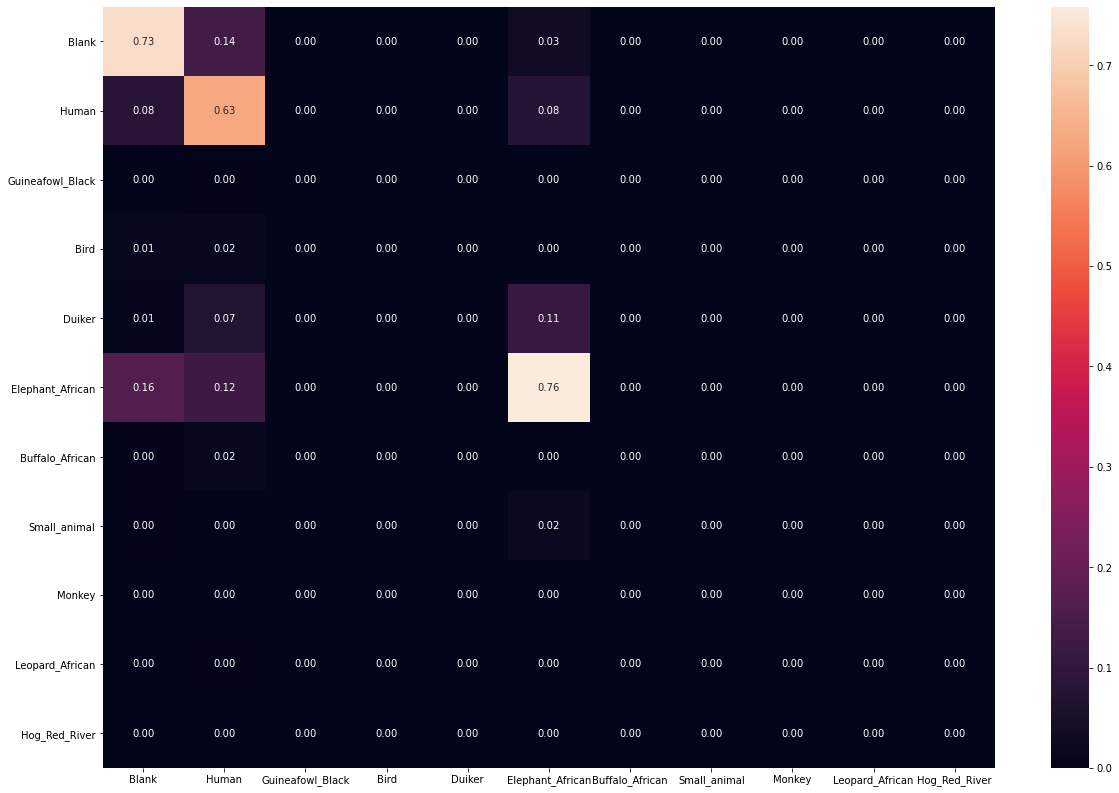

In [48]:
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [ ]:
correctly_classified = {}
total = {}
for idx, i in enumerate(true_categories):
    if i == predicted_categories[idx].numpy():
        if CLASS_NAMES[i] in correctly_classified.keys():
            correctly_classified[CLASS_NAMES[i]] += 1
        else:
            correctly_classified[CLASS_NAMES[i]] = 1
    
    if CLASS_NAMES[i] in total.keys():
        total[CLASS_NAMES[i]] += 1
    else:
        total[CLASS_NAMES[i]] = 1
            
print("correct:", correctly_classified)
print("total:  ", total)

In [2]:
# plt.ion()
# index = 0
# for idx, i in enumerate(test_ds_myan):   
#     for j in i[0]:
# #         if y_pred[index][y_pred[index].argmax()] > 0.90:
#         if predicted_categories[index].numpy() != true_categories[index]:
#             plt.figure(figsize = (16,16))
#             plt.imshow(j)
#             plt.show()
#             print("Prediction: "+ str(CLASS_NAMES[predicted_categories[index].numpy()]))
#             print("True: "+ str(CLASS_NAMES[true_categories[index]]))
#         index+=1

# Results

In [49]:
test_path = "gs://dataset-gabon/train_val_test_csv_Siebren/test_data_siebren_grouped_classes.csv"
test_ds = load_dataset(test_path, BATCH_SIZE, training=False)

In [50]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1, steps=len(test_data)//BATCH_SIZE)
print(test_acc)

340/340 [==============================] - 124s 363ms/step - loss: 1.1131 - accuracy: 0.6691
0.6690946817398071


In [51]:
# plot results
# plt.plot(history.history['accuracy'], label='train_accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')

In [52]:
# plot results
# plt.plot(history.history['loss'], label='train_loss')
# plt.plot(history.history['val_loss'], label = 'train_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.ylim([0, 10])
# plt.legend(loc='lower right')

In [53]:
PREDICTIONS = len(test_data)//BATCH_SIZE
y_test = []
counter = 0
for i in tqdm(test_ds):
    if counter < PREDICTIONS:
        counter += 1
        for j in i[1]:
            y_test.append(np.where(j == True)[0][0])
    else:
        break
print(len(y_test))

340it [01:02,  5.44it/s]

43520


In [54]:
y_pred = model.predict(test_ds, steps=PREDICTIONS)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = y_test
cm = confusion_matrix(predicted_categories, true_categories, normalize="true")
df_cm = pd.DataFrame(cm, index = [i for i in CLASS_NAMES],
                  columns = [i for i in CLASS_NAMES])

<AxesSubplot:>

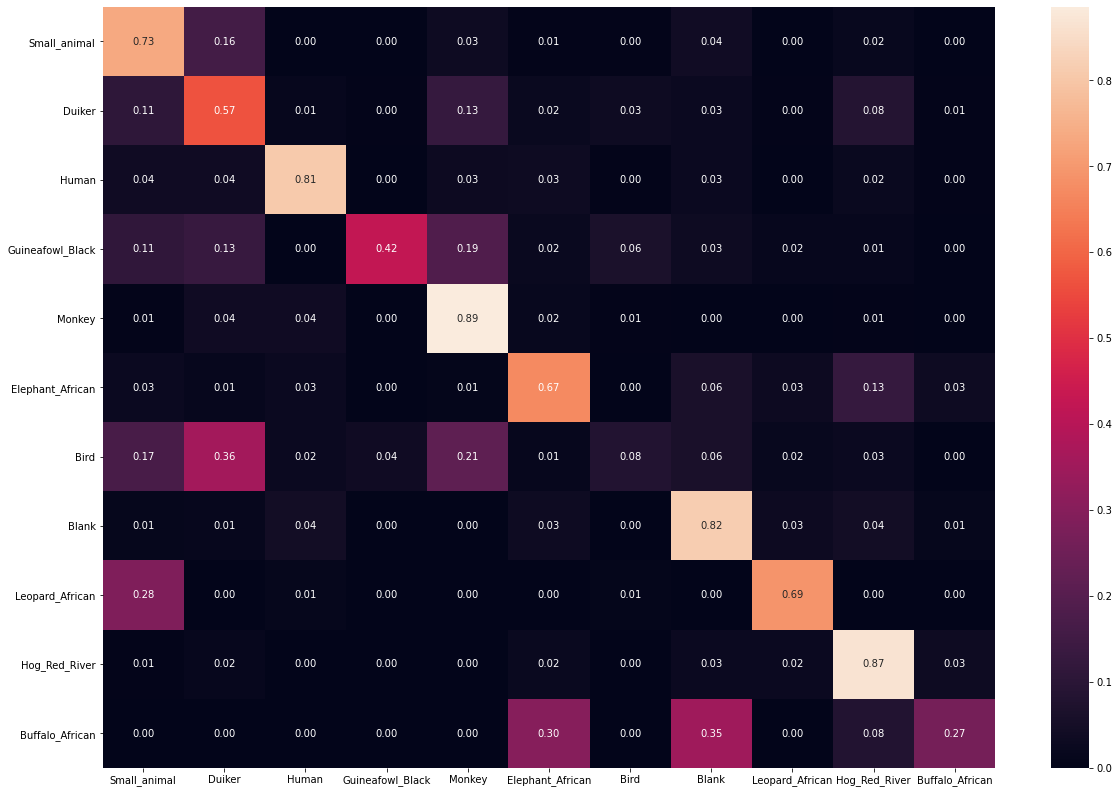

In [55]:
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [56]:
CLASS_NAMES

array(['Small_animal', 'Duiker', 'Human', 'Guineafowl_Black', 'Monkey',
       'Elephant_African', 'Bird', 'Blank', 'Leopard_African',
       'Hog_Red_River', 'Buffalo_African'], dtype=object)

In [59]:
prediction_dict = {'Small_animal':[], 'Duiker':[], 'Guineafowl_Black':[], 'Monkey':[], 'Human':[],
       'Elephant_African':[], 'Bird':[], 'Leopard_African':[],
       'Hog_Red_River':[], 'Elephant_African':[], 'Buffalo_African':[], 'Blank':[]}
index = 0
counter = 0
for idx, i in enumerate(tqdm(test_ds)):
    if counter < PREDICTIONS:
        counter+=1
        for j in i[0]:
            if predicted_categories[index].numpy() != true_categories[index]:
                prediction_dict[CLASS_NAMES[true_categories[index]]].append(predicted_categories[index].numpy())
            index+=1

341it [01:02,  5.44it/s]


In [60]:
for true_classes in prediction_dict.keys():
    classes = []
    for i in range(len(CLASS_NAMES)):
        counter = 0
        for j in prediction_dict[true_classes]:
            if j == i:
                counter +=1
        classes.append(counter)
    prediction_dict[true_classes] = classes

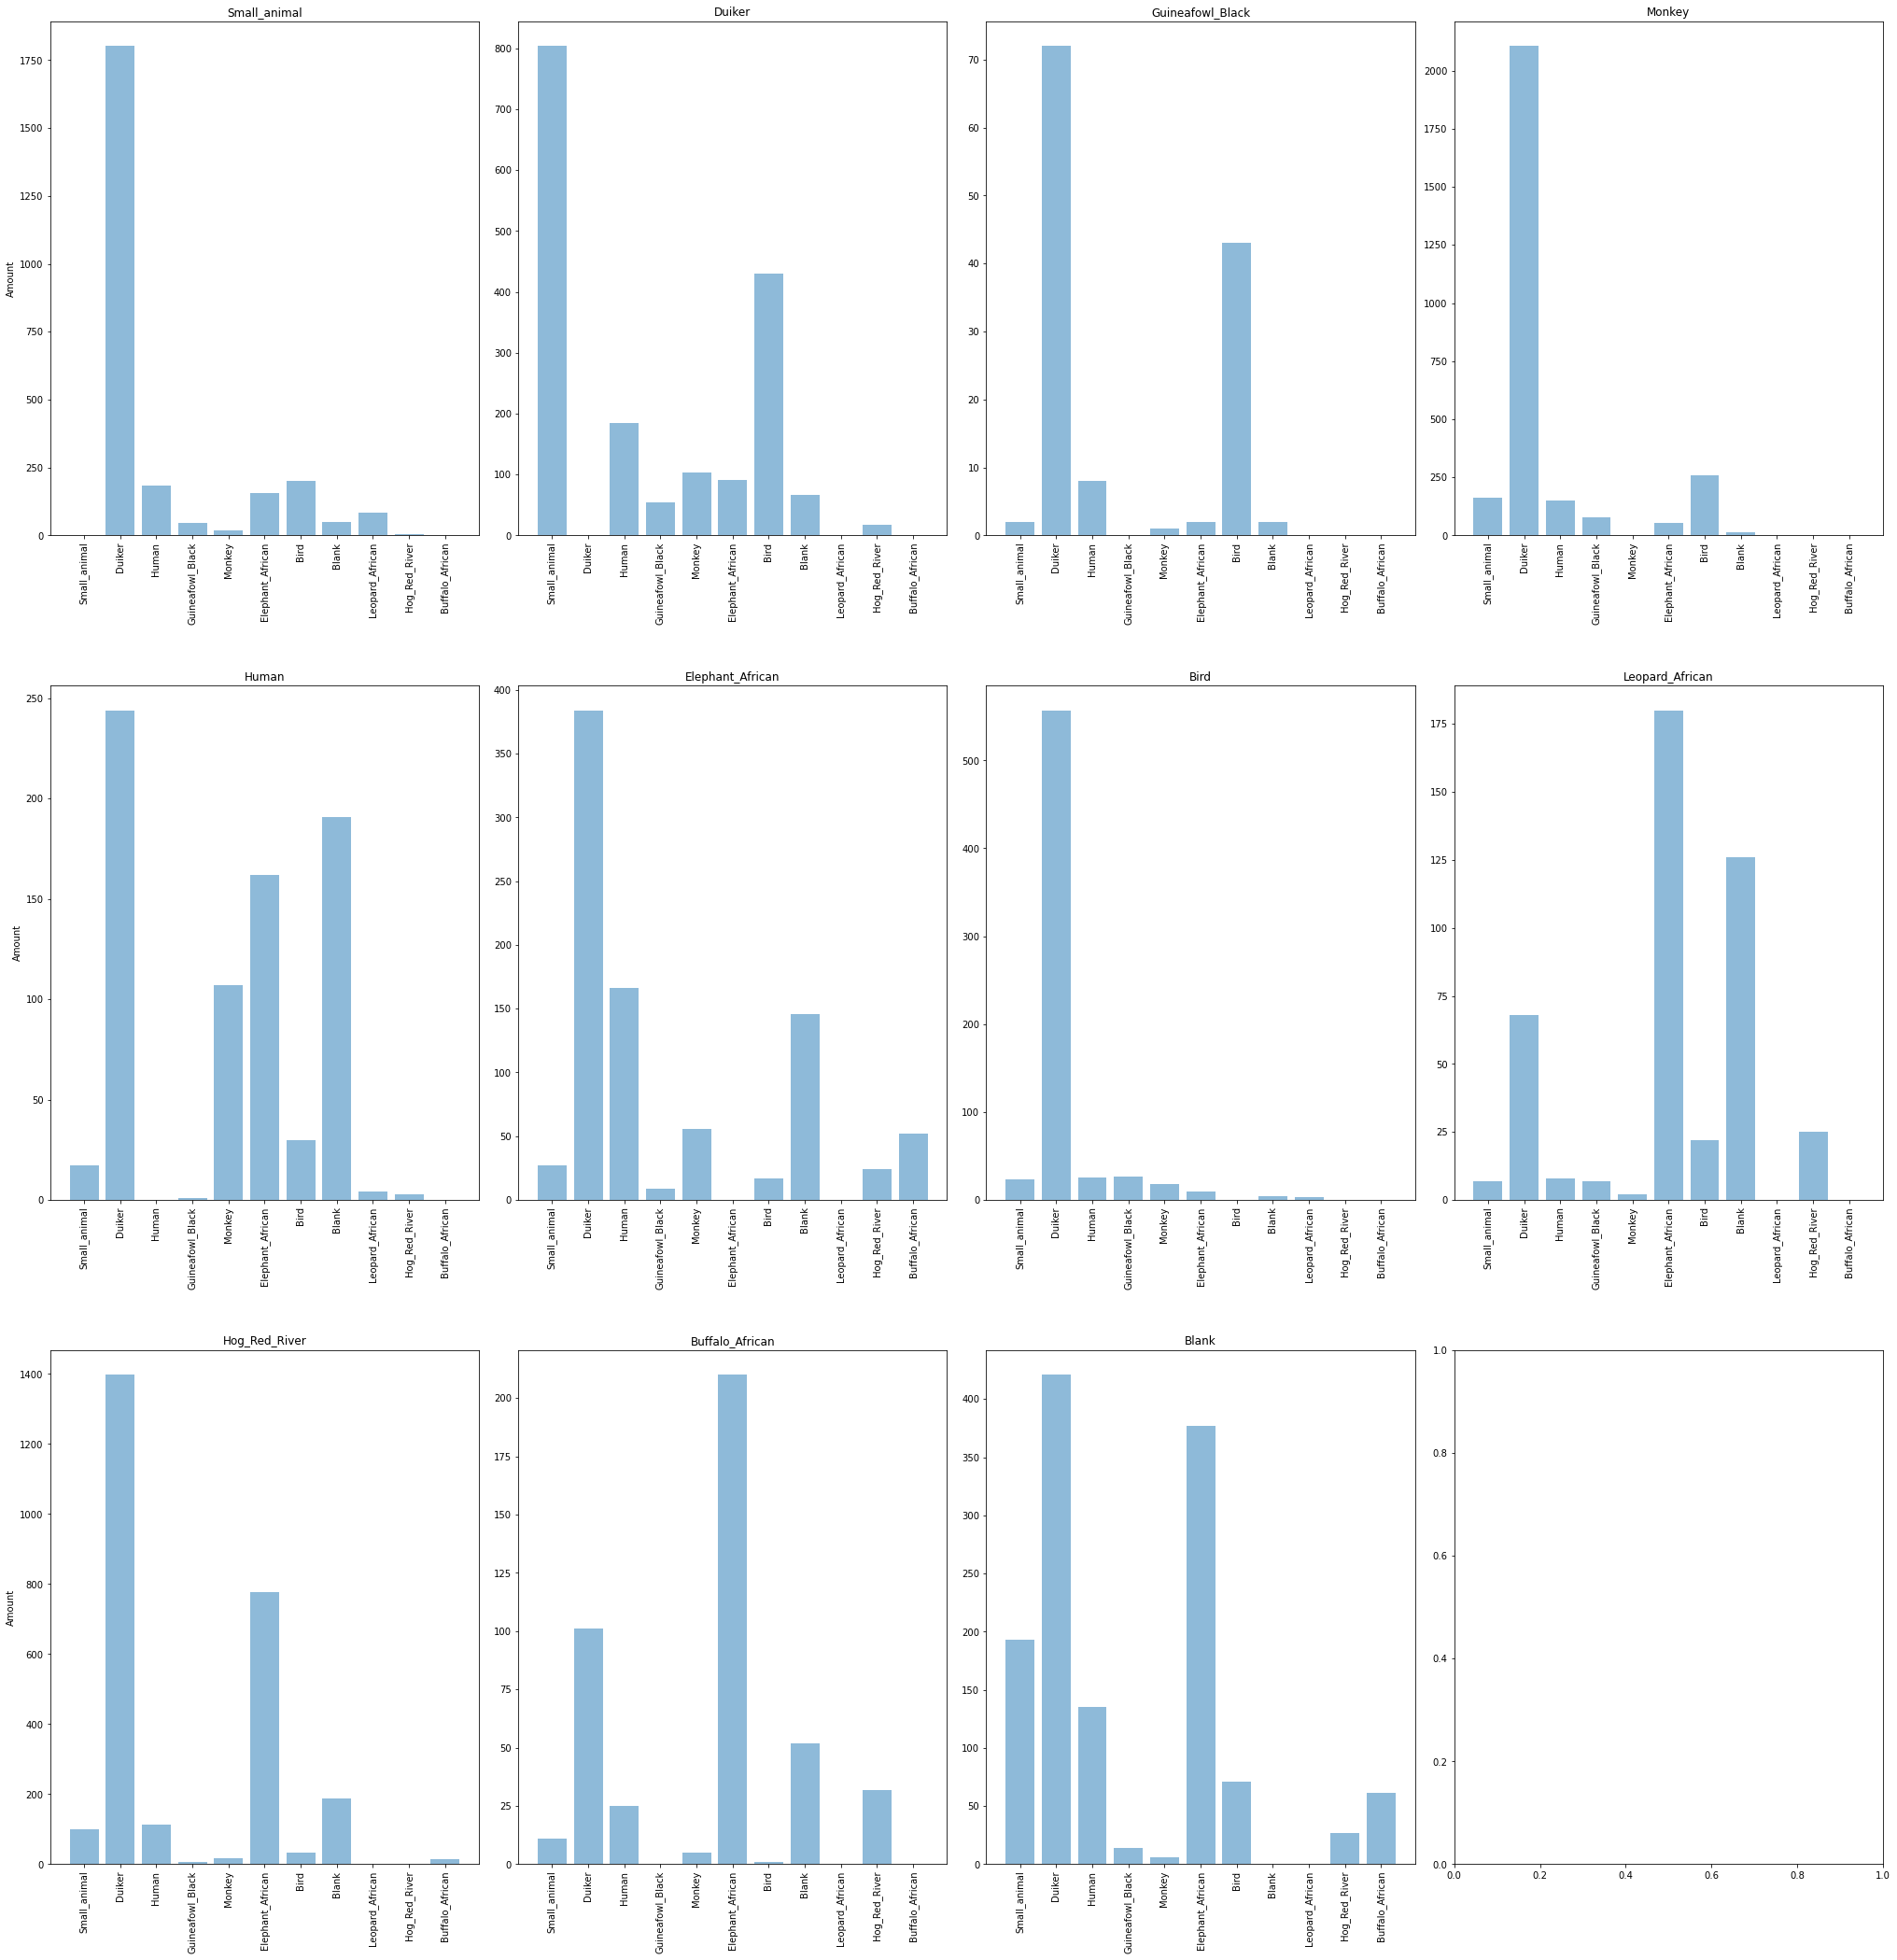

In [62]:
y_pos = np.arange(len(CLASS_NAMES))
f, axarr = plt.subplots(3,4, figsize=(28,28))
f.tight_layout(h_pad=14)

col = 0
row = 0
for name in prediction_dict.keys():
    if col < 4:
        axarr[row][col].bar(y_pos, prediction_dict[name], align='center', alpha=0.5, tick_label=CLASS_NAMES)
        axarr[row][col].set_title(name)
        axarr[row][col].set_xticklabels(CLASS_NAMES, rotation=90)
        axarr[row][0].set_ylabel('Amount')
        col += 1
    else:
        row += 1
        col = 0
        axarr[row][col].bar(y_pos, prediction_dict[name], align='center', alpha=0.5, tick_label=CLASS_NAMES)
        axarr[row][col].set_title(name)
        axarr[row][col].set_xticklabels(CLASS_NAMES, rotation=90)
        axarr[row][0].set_ylabel('Amount')
        col += 1
        
        

In [63]:
train_data.groupby(0).nunique()

,1
0,
Bird,8463
Blank,23956
Buffalo_African,4826
Duiker,59479
Elephant_African,24054
Guineafowl_Black,9403
Hog_Red_River,18020
Human,24104
Leopard_African,1216


In [1]:
# plt.ion()
# index = 0
# for idx, i in enumerate(test_ds):   
#     for j in i[0]:
# #         if y_pred[index][y_pred[index].argmax()] > 0.90:
#         if predicted_categories[index].numpy() != true_categories[index]:
#             plt.figure(figsize = (16,16))
#             plt.imshow(j)
#             plt.show()
#             print("Prediction: "+ str(CLASS_NAMES[predicted_categories[index].numpy()]))
#             print("True: "+ str(CLASS_NAMES[true_categories[index]]))
#         index+=1

# Saves

FileNotFoundError: [Errno 2] No such file or directory: 'gs://dataset-gabon/train_val_test_csv_Siebren/Confusion_matrix/MobileNetV2_5epoch_0.719acc.png'

# Results

MobileNetV2 | 3 epochs training | test acc 0.713 | batch size 128 |

In [ ]:
MobileNetV2 | 5 epochs training | test acc 0.719 | batch size 128 |

In [ ]:
Xception    | 3 epochs training | val acc 0.754  | batch size 128 |

In [ ]:
Xception    | 5 epochs training | val acc 0.761  | batch size 128 |

In [ ]:
Xception    | 5+1 epochs training | val acc 0.765  | batch size 128 |